## A/B-тестирование

АНАЛИЗ ЭФФЕКТИВНОСТИ ДВУХ ВАРИАНТОВ ПОСАДОЧНОЙ СТРАНИЦЫ

Представьте, что вы — Data Scientist в туристической фирме. Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные — скачайте их по ссылке ниже.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.

Вы должны убедиться, что A/B-тестирование было проведено корректно, проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?

Итак, компания предлагает следующие варианты туров:

* Таиланд — 100 000 рублей;
* Турция — 60 000 рублей;
* Мальдивы — 200 000 рублей;
* Санкт-Петербург — 10 000 рублей;
* Камчатка — 150 000 рублей.

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest
import numpy as np
import scipy.stats as stats

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [137]:
data = pd.read_csv('ab_data_tourist.zip')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


Наша таблица представлена следующими полями:

* user_id — идентификатор пользователя, зашедшего на сайт;
* data — дата посещения сайта;
* group — группа теста (контрольная — А или тестовая — B);
* purchase — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет);
* price — цена купленного тура (если покупка не состоялась, цена равна 0).

### **Задание 1. Анализ структуры и предобработка данных (1 балл)**

1. Исследуйте структуру данных

In [138]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


2. Преобразуйте столбцы к необходимым типам данных

In [139]:
data['date'] = pd.to_datetime(data['date'])

3. Убедитесь в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируйте данные, удалив лишние данные для соответствующей группы

In [140]:
data.groupby('group')['date'].describe()

,count,mean,min,25%,50%,75%,max
group,,,,,,,
A,147202,2021-01-13 01:55:49.470795520,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00
B,147276,2021-01-13 01:23:47.034955008,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00


4. Проверьте данные на наличие пропусков и избавьтесь от них, если нужно

In [141]:
missing_data = data.isnull().sum()
missing_data

user_id     0
date        0
group       0
purchase    0
price       0
dtype: int64

5. Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах

In [142]:
mask_A = data[data['group'] == 'A']
mask_B = data[data['group'] == 'B']
user_intersection = set(mask_A['user_id']) \
    .intersection(set(mask_B['user_id']))
print(len(user_intersection))

1895


In [143]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

### **Задание 2. Сделайте первичный анализ результатов A/B-тестирования:**

1. Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

* количество посещений сайта;
* суммарное количество совершённых покупок;
* сумма всех покупок.

Сделайте промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? Можно ли говорить о сбалансированности выборок?

In [144]:
print('Количество посещений сайта:', updated_data.groupby('group')['user_id'].count())
print('Количество совершенных покупок:',  updated_data.groupby('group')['purchase'].sum())
print('Сумма всех покупок (млн):', (updated_data.groupby('group')['price'].sum() / 1_000_000).round(2))

Количество посещений сайта: group
A    145307
B    145381
Name: user_id, dtype: int64
Количество совершенных покупок: group
A    17487
B    17290
Name: purchase, dtype: int64
Сумма всех покупок (млн): group
A    1417.78
B    1533.01
Name: price, dtype: float64


* Количество посещений сайта между группами A и B практически одинаково, разница составляет всего 74 посещения. Это свидетельствует о том, что выборки по количеству посещений сбалансированы.
* Разница в количестве покупок между группами также невелика, всего 197 покупок. Это может свидетельствовать о схожем уровне конверсии в обеих группах, хотя для более точных выводов необходима дополнительная проверка статистической значимости.
* Сумма всех покупок выше в группе B, несмотря на меньшее количество покупок. Это может указывать на то, что средний чек (средняя стоимость покупки) в группе B выше, чем в группе A.

2. В каждой из групп рассчитайте ключевые показатели:

* конверсия;
* средний чек.

Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего чека в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

In [145]:
pivot_tab = updated_data.groupby('group') \
    .agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}) \
    .rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 
             'price': 'sum_price'})
display(pivot_tab)

,count_visits,count_purchases,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


In [146]:
pivot_tab['conversion'] \
    = (pivot_tab['count_purchases'] / pivot_tab['count_visits'] * 100).round(2)
pivot_tab['mean_bill'] \
    = (pivot_tab['sum_price'] / pivot_tab['count_purchases']).round()
display(pivot_tab)

,count_visits,count_purchases,sum_price,conversion,mean_bill
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


* Вариант A демонстрирует более высокую конверсию, что означает, что данный вариант более эффективен в превращении посетителей в покупателей. Если основной приоритет — увеличение количества покупок, то вариант A может быть предпочтительным.
* Вариант B показывает более высокий средний чек, что свидетельствует о том, что пользователи в этой группе тратят больше за покупку. Если основной приоритет — увеличение дохода от каждой покупки, то вариант B может быть предпочтительным.

3. Сравните варианты A/B по покупательской способности каждого из туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. Визуализируйте полученную сводную таблицу.

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем покупательская способность участников группы B, и наоборот?

In [147]:
pivot_tab_2 = pd.pivot_table(updated_data, 
    values='purchase', index='group', columns='price', aggfunc='count')
pivot_tab_2.drop(0, axis=1, inplace=True)
display(pivot_tab_2)

price,10000,60000,100000,150000,200000
group,,,,,
A,5182,5271,1832,3478,1724
B,5201,1730,5227,3438,1694


<Axes: xlabel='price', ylabel='group'>

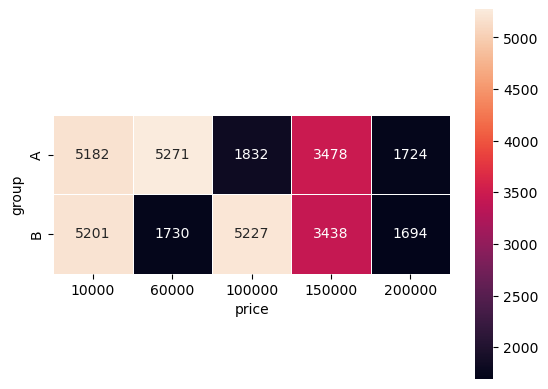

In [148]:
sns.heatmap(pivot_tab_2, 
    annot = True, 
    fmt='1g', 
    square = True, 
    linewidths=0.5, 
    linecolor='white'
            )

* Группа A имеет выше покупательскую способность по средним ценовым диапазонам (60,000 руб.) и схожую покупательскую способность по низким и самым высоким ценовым диапазонам (10,000 руб., 200,000 руб.).
* Группа B имеет выше покупательскую способность по высоким ценовым диапазонам (100,000 руб.)

### **Задание 3. Сгруппируйте данные по дате и группе тестирования и постройте таблицу с ежедневными данными результатов проведения A/B-тестирования.**

1. В каждой группе вычислите ежедневные показатели:

* количество посещений страницы;
* количество покупок;
* сумму покупок. 

In [149]:
pivot_tab

,count_visits,count_purchases,sum_price,conversion,mean_bill
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


2. Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [150]:
daily = updated_data.groupby(['date', 'group']) \
    .agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'}) \
    .rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchases', 
             'price': 'sum_price'})
daily['conversion'] \
    = (daily['count_purchases'] / daily['count_visits'] * 100).round(2)
daily['mean_bill'] \
    = (daily['sum_price'] / daily['count_purchases']).round()

daily

count_visits  count_purchases  sum_price  conversion  \
date       group                                                         
2021-01-02 A              2854              359   29410000       12.58   
           B              2861              345   29660000       12.06   
2021-01-03 A              6596              748   62000000       11.34   
           B              6619              754   65960000       11.39   
2021-01-04 A              6566              799   64250000       12.17   
           B              6536              764   68030000       11.69   
2021-01-05 A              6433              790   64550000       12.28   
           B              6511              749   63550000       11.50   
2021-01-06 A              6606              764   63410000       11.57   
           B              6751              838   75020000       12.41   
2021-01-07 A              6579              795   67290000       12.08   
           B              6616              767   67170000       11.59   
2021-01-08 A              6687              798   65380000       11.93   
           B              6714              812   71270000       12.09   
2021-01-09 A              6633              794   65610000       11.97   
           B              6628              784   71410000       11.83   
2021-01-10 A              6659              759   58950000       11.40   
           B              6701              846   78080000       12.62   
2021-01-11 A              6699              797   58760000       11.90   
           B              6679              770   66960000       11.53   
2021-01-12 A              6540              795   68460000       12.16   
           B              6635              807   70560000       12.16   
2021-01-13 A              6564              764   63590000       11.64   
           B              6495              720   65910000       11.09   
2021-01-14 A              6543              825   65890000       12.61   
           B              6608              792   68990000       11.99   
2021-01-15 A              6701              806   67570000       12.03   
           B              6563              747   69160000       11.38   
2021-01-16 A              6601              808   66210000       12.24   
           B              6544              786   70560000       12.01   
2021-01-17 A              6619              809   63020000       12.22   
           B              6546              831   75300000       12.69   
2021-01-18 A              6511              812   62850000       12.47   
           B              6603              822   72240000       12.45   
2021-01-19 A              6582              790   63680000       12.00   
           B              6562              772   67820000       11.76   
2021-01-20 A              6533              749   58710000       11.46   
           B              6685              790   69250000       11.82   
2021-01-21 A              6750              851   70300000       12.61   
           B              6555              760   69870000       11.59   
2021-01-22 A              6587              788   63690000       11.96   
           B              6659              787   68660000       11.82   
2021-01-23 A              6698              843   70950000       12.59   
           B              6633              805   68930000       12.14   
2021-01-24 A              3766              444   33250000       11.79   
           B              3677              442   38650000       12.02   

                  mean_bill  
date       group             
2021-01-02 A        81922.0  
           B        85971.0  
2021-01-03 A        82888.0  
           B        87480.0  
2021-01-04 A        80413.0  
           B        89045.0  
2021-01-05 A        81709.0  
           B        84846.0  
2021-01-06 A        82997.0  
           B        89523.0  
2021-01-07 A        84642.0  
           B        87575.0  
2021-01-08 A        81930.0  
           B   

3. Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

In [151]:
daily['cumul_visits'] = daily.groupby('group')['count_visits'].cumsum()
daily['cumul_purchases'] = daily.groupby('group')['count_purchases'].cumsum()
daily['cumul_price'] = daily.groupby('group')['sum_price'].cumsum()

4. Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

In [152]:
daily['cumul_conversion'] \
    = (daily['cumul_purchases'] / daily['cumul_visits'] * 100).round(2)
daily['cumul_mean_bill'] \
    = (daily['cumul_price'] / daily['cumul_purchases']).round()

5. Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням.

Сделайте выводы. Можно ли назвать A/B-тест завершённым? Стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

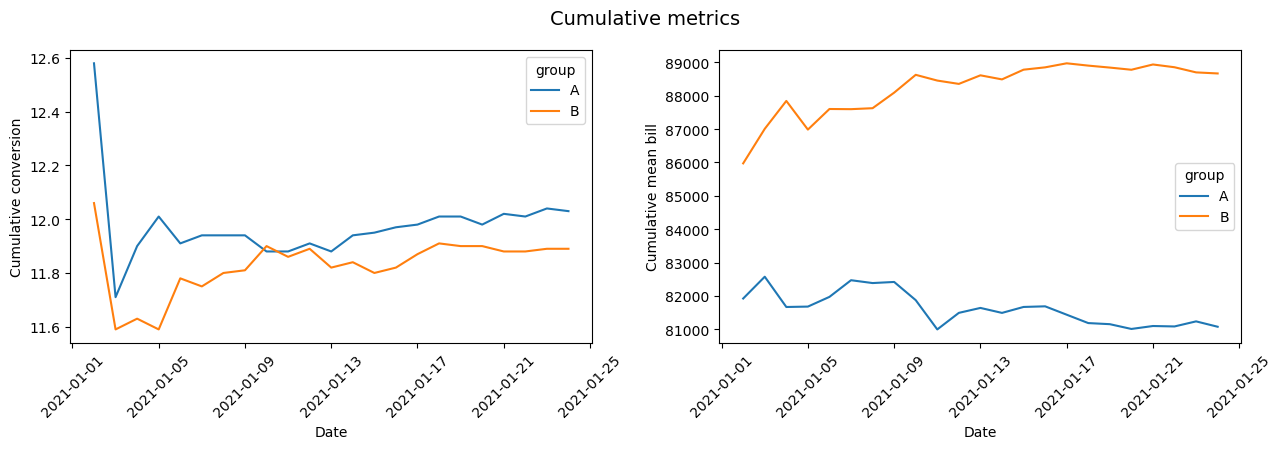

In [153]:
fig, ax = plt.subplots(1, 2, figsize=(13, 4))
sns.lineplot(data=daily.reset_index(), 
             x='date', y='cumul_conversion', hue='group', ax=ax[0])
sns.lineplot(data=daily.reset_index(), 
             x='date', y='cumul_mean_bill', hue='group', ax=ax[1])
fig.subplots_adjust(top=.85)
fig.suptitle('Cumulative metrics', fontsize=14)
plt.tight_layout()
ax[0].xaxis.set_tick_params(rotation=45)
ax[1].xaxis.set_tick_params(rotation=45)
ax[0].set(xlabel='Date', ylabel='Cumulative conversion')
ax[1].set(xlabel='Date', ylabel='Cumulative mean bill');

* Кумулятивные метрики стабилизировались, A/B-тестирование можно считать завершенным. 
* Кумулятивная конверсия в тестовой группе (B) несколько меньше конверсии в контрольной группе (A). 
* Кумулятивный средний чек тестовой группы выше с первого дня и на всем протяжении тестирования

### **Задание 4. Проведите статистический анализ результатов A/B-тестирования**

Сформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберите статистический тест для их проверки.

Не забудьте проверить данные на нормальность там, где это необходимо.

Есть ли статистически значимая разница в конверсии между группами A и B? 

* Нулевая гипотеза (H0): Конверсия в группе A равна конверсии в группе B. 
* Альтернативная гипотеза (H1): Конверсия в группе A не равна конверсии в группе B.

Есть ли статистически значимая разница в среднем чеке между группами A и B?

* Нулевая гипотеза (H0): Средний чек в группе A равен среднему чеку в группе B.
* Альтернативная гипотеза (H1): Средний чек в группе A не равен среднему чеку в группе B.

Тест Шапиро-Уилка: Подходит для проверки нормальности распределения данных в выборке. Можно использовать scipy.stats.shapiro().

Если данные нормальны, используем t-тест для сравнения средних значений:
* Независимый t-тест (Student's t-test): Для сравнения двух независимых выборок: scipy.stats.ttest_ind().

Если данные не нормальны, используем непараметрический тест:
* Тест Манна-Уитни (U-тест): Для сравнения двух независимых выборок, когда данные не нормальны: scipy.stats.mannwhitneyu().

Z-тест для пропорций (Z-критерий). Самый популярный критерий для определения статистической значимости изменения конверсии.

In [154]:
daily = daily.reset_index() 

mean_bill_A = daily[daily['group'] == 'A']['mean_bill']
mean_bill_B = daily[daily['group'] == 'B']['mean_bill']

_, p = shapiro(mean_bill_A)
print(f'Группа A, p-value = {p:.3f}')

_, p = shapiro(mean_bill_B)
print(f'Группа B, p-value = {p:.3f}')

Группа A, p-value = 0.253
Группа B, p-value = 0.094


В обеих группах p-value превышает установленный уровень значимости (0,05), следовательно нулевая гипотеза не отвергается, распределения можно считать нормальными.

2. С помощью аппарата статистических тестов определите:

* Есть ли статистическая разница между конверсиями в группах А и B?
* Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [155]:
converted_piv = updated_data.groupby('group')['purchase'].agg(
    ['count', 'sum']).reset_index()
display(converted_piv)

,group,count,sum
0,A,145307,17487
1,B,145381,17290


In [156]:
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число «успехов»
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='two-sided',
)
# выводим результат на экран
print('p-value: ', round(p_value, 3))
# сравниваем полученное p-value с уровнем значимости
if (p_value <= alpha):
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value:  0.239
У нас нет оснований отвергнуть нулевую гипотезу


In [157]:
alpha = 0.05 #уровень значимости
results = ttest_ind(mean_bill_A, mean_bill_B)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 0.0
Отвергаем нулевую гипотезу в пользу альтернативной


3. Подкрепите результаты статистических тестов, построив 95 % доверительные интервалы для:

* конверсий в каждой из групп;
* разницы конверсий в группах;
* ежедневного среднего чека в каждой из групп.

In [158]:
# фильтруем данные группы А
a_data = updated_data[updated_data['group'] == 'A']
# фильтруем данные группы B
b_data = updated_data[updated_data['group'] == 'B']

In [159]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [160]:
# строим доверительный интервал для конверсии в группе А
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=a_data['purchase'].mean(), # выборочная пропорция
    n=a_data['user_id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе B
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=b_data['purchase'].mean(), # выборочная пропорция
    n=b_data['user_id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе А: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе B: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе А: (11.87, 12.2)
Доверительный интервал для конверсии в группе B: (11.73, 12.06)


In [161]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [162]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
x_p = [a_data['purchase'].mean(), b_data['purchase'].mean()]

# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)

# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.38, 0.09)


In [163]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    t_crit = -t.ppf(alpha/2, n-1) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound


n = len(mean_bill_A)         # размер выборки A      
x_mean = mean_bill_A.mean()  # средний чек, усредненный по выборке A
x_std = mean_bill_A.std()       # выборочная дисперсия
conf_interval = t_mean_conf_interval(x_mean, x_std, n)
print('Выборка A, доверительный интервал (95%):', 
      '%.0f'%conf_interval[0], '%.0f'%conf_interval[1])

n = len(mean_bill_B)         # размер выборки B     
x_mean = mean_bill_B.mean()  # средний чек, усредненный по выборке B
x_std = mean_bill_B.std()       # выборочная дисперсия
conf_interval = t_mean_conf_interval(x_mean, x_std, n)
print('Выборка B, доверительный интервал (95%):', 
      '%.0f'%conf_interval[0], '%.0f'%conf_interval[1])

Выборка A, доверительный интервал (95%): 79630 82308
Выборка B, доверительный интервал (95%): 87626 89526


* Так как интервалы для конверсий в группах A и B частично перекрываются, это указывает на то, что нет статистически значимой разницы в конверсиях между группами A и B на уровне значимости 0.05 (то есть, на уровне доверия 95%).
* Этот интервал включает 0, что также подтверждает отсутствие статистически значимой разницы в конверсиях между группами A и B. То есть, мы не можем утверждать, что одна группа лучше другой с точки зрения конверсии.
* Перекрытие между интервалами ежедневного среднего чека в каждой из групп отсутствует, что указывает на значимую разницу в среднем чеке между группами A и B. Это значит, что группа B, скорее всего, имеет более высокий средний чек, чем группа A.

### **Задание 5.Сделайте общий вывод по результатам A/B-теста.**

Какой варианта дизайна посадочной страницы более эффективен по метрикам конверсии и ежедневного среднего чека и почему?

* Доверительные интервалы для конверсий в группах A и B частично перекрываются, и доверительный интервал для разности конверсий включает 0. Это говорит о том, что нет статистически значимой разницы в конверсии между двумя вариантами дизайна. Таким образом, по метрике конверсии нельзя сказать, что один вариант дизайна более эффективен, чем другой.
* Доверительные интервалы для среднего чека не перекрываются, что указывает на статистически значимую разницу между группами. Группа B имеет более высокий средний чек, чем группа A. Это говорит о том, что пользователи, взаимодействующие с посадочной страницей B, тратят в среднем больше денег, чем пользователи на странице A.
* Вариант дизайна B более эффективен по метрике среднего чека, что может свидетельствовать о его предпочтительности, особенно если целью является максимизация дохода. Если же приоритетом является конверсия, то существенной разницы между вариантами нет.